# Notes about tessellation scheme for Roman

## Genesis of the tessellation

1. Healpix
2. Double pixelization
3. Voronoi
4. Roman tessellation

## Double pixelization & Voronoi

In [52]:
# Common packages
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import healpy as hp

In [53]:
from skymap.skymap import doublepixelization

NSIDE = 3
radius = 1
ntheta, nphi, vertices = doublepixelization(NSIDE,radius)


from scipy.spatial import SphericalVoronoi, geometric_slerp
from mpl_toolkits.mplot3d import proj3d
import numpy as np
from skymap.skymap import ang2point

radius = 1
center = [0,0,0]
points = ang2point(90 - ntheta, nphi,radius)
# Voronoi
sv = SphericalVoronoi(points, radius, center)

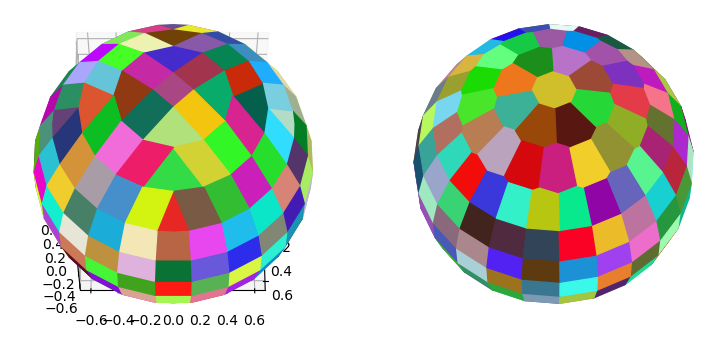

In [54]:
# Double pixelization: polygons
#%matplotlib ipympl
%matplotlib inline
from matplotlib import colors
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
from skymap.skymap import ang2point
import numpy as np

fig = plt.figure(figsize=(9,5))
ax = fig.add_subplot(121, projection='3d',aspect='equal') 
a = 0.65; ax.set_xlim(-a,a); ax.set_ylim(-a,a); ax.set_zlim(-a,a)#; ax.set_axis_off()
for n, vertices_ in enumerate(vertices):
    random_color = colors.rgb2hex(np.random.rand(3))
    polygon = Poly3DCollection([vertices_], alpha=1)
    polygon.set_color(random_color)
    ax.add_collection3d(polygon)
    #print(n, vertices_)
  
# Update the axis view and title
elev = 60; azim = 0; roll = 0
ax.view_init(elev, azim, roll)

ax = fig.add_subplot(122, projection='3d',aspect='equal') 
a=0.65; ax.set_xlim(-a,a); ax.set_ylim(-a,a); ax.set_zlim(-a,a); ax.set_axis_off()
sv.sort_vertices_of_regions()
for n in range(0, len(sv.regions)):
    region = sv.regions[n]
    random_color = colors.rgb2hex(np.random.rand(3))
    polygon = Poly3DCollection([sv.vertices[region]], alpha=1)
    polygon.set_color(random_color)
    ax.add_collection3d(polygon)
 
# Update the axis view and title
elev = 60; azim = 20; roll = 0
ax.view_init(elev, azim, roll)
plt.show()


## Roman tessellation

### Computing N

N is the number of subdivisions of a diamond in the Healpix scheme. N is linked to the area of a tile, since the tessellation approximately subdivides the sphere in equal area spherical polygons.

In [55]:
# Number of sky cells (or tessels)
import math

Nside = 40
Nhp = 12 * Nside**2
Ndp = 2 * Nhp + 2
# FOV = 4 * np.pi / (Ndp-2) # Double pixelization
FOV = 4 * np.pi / (Ndp-2) # Roman tessellation
Size = np.sqrt(FOV) * 180/np.pi
print('N {0:d} Nd {1:d} Cell side {2:.2f} degs'.format(Nside, Ndp, Size))

pixsize = 0.05/3600
print('Number of pixels on one side', int(np.sqrt(FOV)* (180/np.pi) / pixsize))

N 40 Nd 38402 Cell side 1.04 degs
Number of pixels on one side 74626


### Obtaining the tiles

In [56]:
from skymap.skymap import romantessellation

NSIDE = 10
radius = 1
ntheta, nphi, vertices = romantessellation(NSIDE,radius)
print(len(ntheta))

2402


### Projection on a sphere

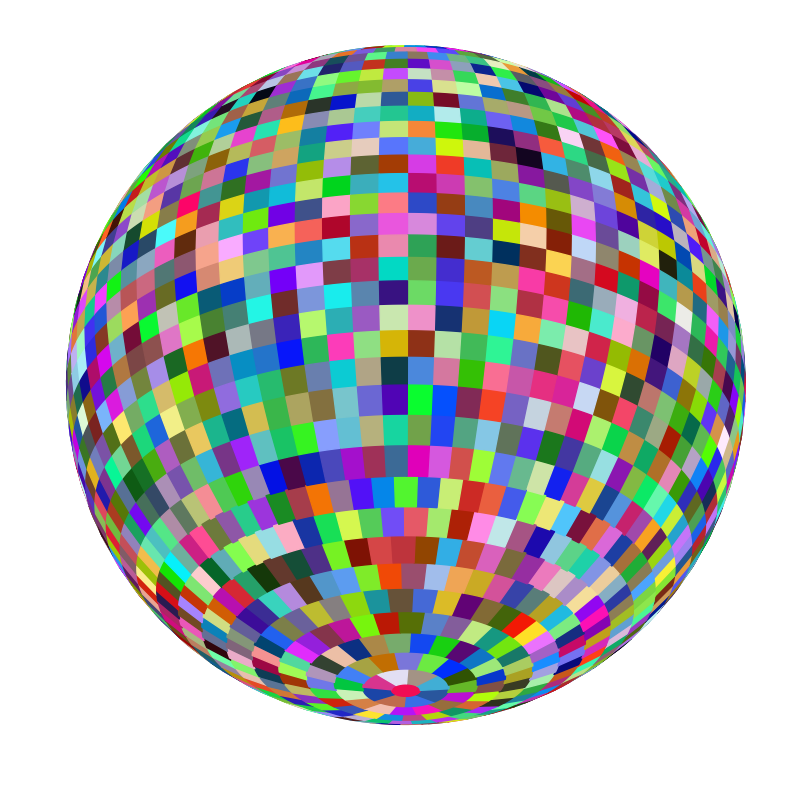

In [57]:
# Double pixelization: polygons
#%matplotlib ipympl
%matplotlib inline
from matplotlib import colors
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
from skymap.skymap import ang2point
import numpy as np

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d',aspect='equal') 
a = 0.65; ax.set_xlim(-a,a); ax.set_ylim(-a,a); ax.set_zlim(-a,a)#; ax.set_axis_off()
for n, vertices_ in enumerate(vertices):
    random_color = colors.rgb2hex(np.random.rand(3))
    polygon = Poly3DCollection([vertices_], alpha=1)
    polygon.set_color(random_color)
    ax.add_collection3d(polygon)
    #print(n, vertices_)
  
# Update the axis view and title
elev = -30; azim = 20; roll = 0
ax.view_init(elev, azim, roll)
ax.set_axis_off() 
plt.show()


### Lambert projection of tiles

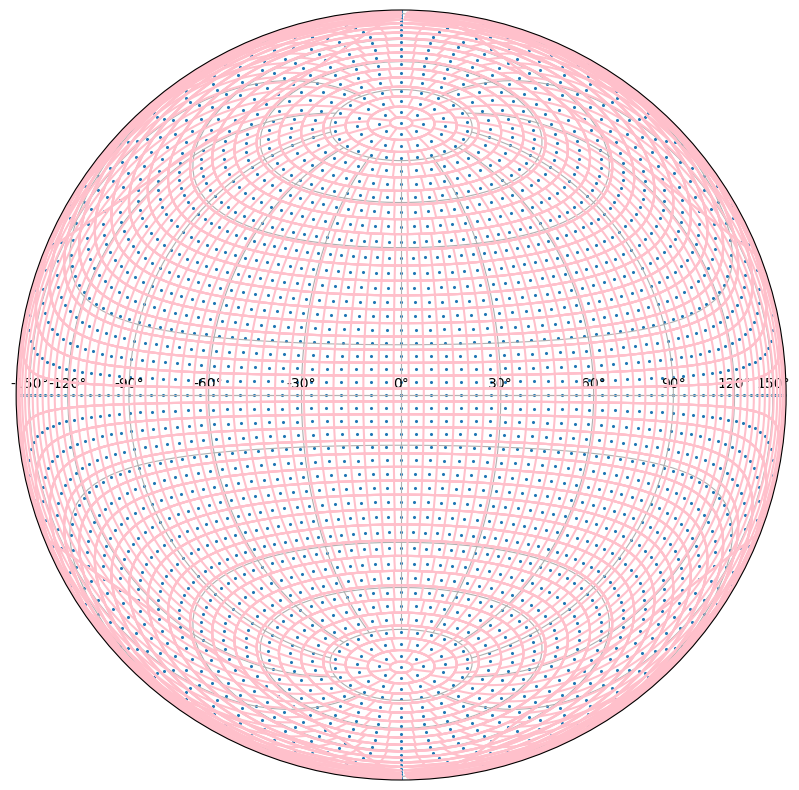

In [58]:
%matplotlib inline
from astropy.coordinates import cartesian_to_spherical as cart2sph
from skymap.skymap import ang2point
from scipy.spatial import SphericalVoronoi, geometric_slerp
import healpy as hp
import sys
from skymap.skymap import doublepixelization

NSIDE = 10
radius = 1
ntheta, nphi, vertices = romantessellation(NSIDE,radius)

radius = 1
center = [0,0,0]
points = ang2point(90 - ntheta, nphi,radius)

    
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='lambert',aspect='equal') 
#ax = fig.add_subplot(111, projection='mollweide',aspect='equal') 
plt.grid(True)
plt.scatter(np.deg2rad(180-nphi),np.deg2rad(90-ntheta),marker='.',s=6)
#ax.set_axis_off()
# Voronoi
sv = SphericalVoronoi(points, radius, center)
sv.sort_vertices_of_regions()
plotVoronoi = False
if plotVoronoi:
    for n in range(0, len(sv.regions)):
        region = sv.regions[n]
        vvertices = sv.vertices[region]
        ra = []
        dec = []
        for vertex in vvertices:
            x,y,z = vertex
            pol = cart2sph(x,y,z)
            ra.append(pol[2].value)
            dec.append(pol[1].value)
        ra.append(ra[0])
        dec.append(dec[0])
        ra = np.rad2deg(np.array(ra))-180
        dec = np.rad2deg(np.array(dec))
        #print('ra  ', ra)
        #print('dec ', dec)
        plt.plot(np.deg2rad(ra), np.deg2rad(dec), color='pink')

for vertices_ in vertices:
        ra = []
        dec = []
        for n, vertex in enumerate(vertices_):
            x,y,z = vertex
            pol = cart2sph(x,y,z)
            r = pol[2].value
            ra.append(r)
            dec.append(pol[1].value)
        ra = np.array(ra)
        ra =  np.rad2deg(ra)
        medra = np.nanmedian(ra)
        if medra >= 270:
            id = ra == 0.
            ra[id] += 360
        dec = np.rad2deg(np.array(dec))
        plt.plot(np.deg2rad(ra-180), np.deg2rad(dec), color='pink')
               
plt.show()    
#fig.savefig('tessellation.png',bbox_inches="tight", pad_inches=0.2, transparent=True)

### Mollweide projection of tiles

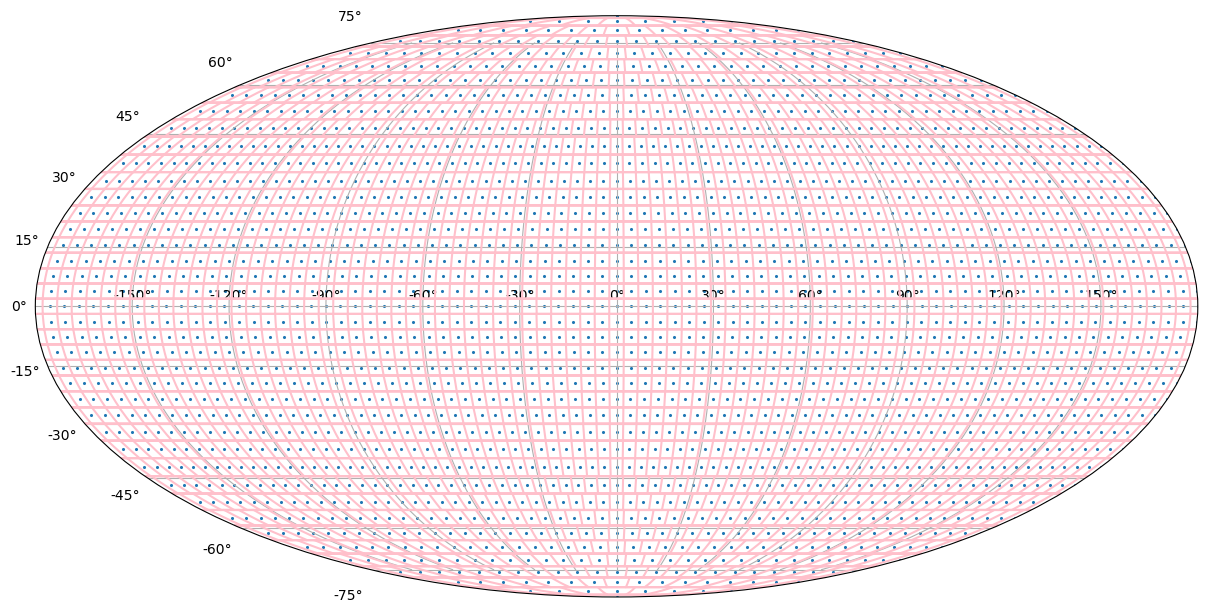

In [59]:
fig = plt.figure(figsize=(15,10))
#ax = fig.add_subplot(111, projection='lambert',aspect='equal') 
ax = fig.add_subplot(111, projection='mollweide',aspect='equal') 
plt.grid(True)
plt.scatter(np.deg2rad(180-nphi),np.deg2rad(90-ntheta),marker='.',s=6)

for vertices_ in vertices:
        ra = []
        dec = []
        for n, vertex in enumerate(vertices_):
            x,y,z = vertex
            pol = cart2sph(x,y,z)
            r = pol[2].value
            ra.append(r)
            dec.append(pol[1].value)
        ra = np.array(ra)
        ra =  np.rad2deg(ra)
        medra = np.nanmedian(ra)
        if medra >= 270:
            id = ra == 0.
            ra[id] += 360
        dec = np.rad2deg(np.array(dec))
        plt.plot(np.deg2rad(ra-180), np.deg2rad(dec), color='pink')
               
plt.show()    

### Plotting a tile
in x-y tangential projection

In [60]:
from astropy.wcs import WCS

wcs = WCS(naxis=2)
wcs.wcs.crpix = [0., 0.]
pix = .05/3600
wcs.wcs.cdelt = [pix,pix]
#wcs.wcs.crval = [23.2334, 45.2333]
wcs.wcs.ctype = ["RA---TAN", "DEC--TAN"]

# Points
NSIDE = 40
radius = 1
ntheta, nphi, vertices = doublepixelization(NSIDE,radius)
radius = 1
center = [0,0,0]
points = ang2point(90 - ntheta, nphi,radius)
sv = SphericalVoronoi(points, radius, center)
sv.sort_vertices_of_regions()
print(len(vertices))

38402


ra2  [358.3125 359.4375 359.4375 358.3125 358.3125]
dec2 [-1.43254374 -1.43254374 -2.38801546 -2.38801546 -1.43254374]
ramin max  358.31250000000006 359.43749999999983
Latitude difference:  57.32830354213616 arcmin
delta  600.0
Dx, Dy Area 80980.09611841985 68803.83576633123 0.005571741233673477


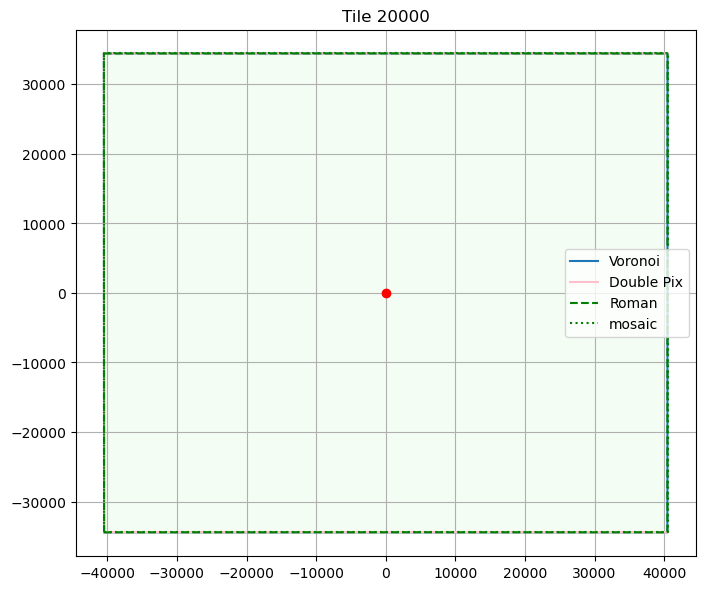

In [71]:
def limits(a, b, ax):
    if a>b : a, b = b, a
    ymin, ymax = ax.get_ylim()
    dy = ymax-ymin
    return ((y-ymin)/dy for y in (a, b))


# Projection of a tile
itile = 20000
wcs.wcs.crval = [nphi[itile], 90-ntheta[itile]]

# Voronoi
region = sv.regions[itile]
vvertices = sv.vertices[region]
ra = []
dec = []
for vertex in vvertices:
    x,y,z = vertex
    pol = cart2sph(x,y,z)
    ra.append(pol[2].value)
    dec.append(pol[1].value)
    
ra.append(ra[0])
dec.append(dec[0])
ra = np.rad2deg(np.array(ra))
dec = np.rad2deg(np.array(dec))   


# 2ble pixelization
ra2 = []
dec2 = []
vertices_ = vertices[itile]
for vertex in vertices_:
    x,y,z = vertex
    pol = cart2sph(x,y,z)
    ra2.append(pol[2].value)
    dec2.append(pol[1].value)
dec2.append(dec2[0])
medra = np.nanmedian(np.rad2deg(np.array(ra2)))
ra2.append(ra2[0])
ra2 =  np.rad2deg(np.array(ra2))

values, counts = np.unique(dec2, return_counts=True)
if medra >= 270:
    id = ra2 == 0.
    ra2[id] += 360
#elif medra <= 90:
#    id = ra2 > 270.
#    ra2[id] -= 360
    
dec2 = np.rad2deg(np.array(dec2))
print('ra2 ', ra2)
print('dec2', dec2)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, aspect='equal') 
x,y = wcs.wcs_world2pix(ra, dec, 1)
plt.plot(x,y,label='Voronoi')
x2,y2 = wcs.wcs_world2pix(ra2, dec2, 1)
x0,y0 = wcs.wcs_world2pix(nphi[itile], 90-ntheta[itile], 1)
plt.plot([x0],[y0],'or')


if itile == 0:
    a = 360*np.arange(0,1.01,0.01)
    d = dec2[0] * np.ones(len(a))
    xi,yi = wcs.wcs_world2pix(a, d, 1)
    plt.plot(xi,yi,color='pink',label='DoublePix')
    plt.plot(xi,yi,color='green',ls='--',label='Roman')
    xmin, xmax = np.nanmin(xi), np.nanmax(xi)
    ymin, ymax = np.nanmin(yi), np.nanmax(yi)
    ax.axvspan(xmin, xmax, *limits(ymin,ymax, ax), color='lightgreen',alpha=0.1)
    plt.plot([xmin,xmax,xmax,xmin,xmin],[ymin,ymin,ymax,ymax,ymin],ls=':',color='green',label='mosaic')
else:
    dra = ra2[1]-ra2[0]
    a = ra2[0]+dra*np.arange(0,1.05,0.05)
    d = np.ones(len(a))*dec2[0]
    xi,yi = wcs.wcs_world2pix(a, d, 1)
    plt.plot(xi,yi,color='pink')
    dra = ra2[3]-ra2[2]
    a = ra2[2]+dra*np.arange(0,1.05,0.05)
    d = np.ones(len(a))*dec2[2]
    xi,yi = wcs.wcs_world2pix(a, d, 1)
    plt.plot(xi,yi,color='pink')
    if np.nanmin(counts) == 1:
        plt.plot(x2[2:4],y2[2:4],color='pink')
    else:
        plt.plot(x2[1:3],y2[1:3],color='pink')
    plt.plot(x2[-2:],y2[-2:],color='pink',label='Double Pix')


    idx = np.argmin(y)
    ymin = y[idx]
    _,decmin = wcs.wcs_pix2world(x[idx],y[idx],1)
    idx = np.argmax(y)
    ymax = y[idx]
    _,decmax = wcs.wcs_pix2world(x[idx],y[idx],1)
    idx = np.argmin(x)
    xmin = x[idx]
    ramin, _ = wcs.wcs_pix2world(x[idx],y[idx],1)
    idx = np.argmax(x)
    xmax = x[idx]
    ramax,_ = wcs.wcs_pix2world(x[idx],y[idx],1)
    if ramin > ramax:
        ramin -= 360
        idx = ra2 > 270
        ra2 -= 360
    print('ramin max ', ramin, ramax)

    decmin = np.min(dec2)
    decmax = np.max(dec2)
    print('Latitude difference: ', (decmax-decmin)*60, 'arcmin')

    delta = 0.5/60/pix # half minute overlap
    print('delta ', delta)

    dra = ramax-ramin
    a = ramin+dra*np.arange(0,1.05,0.05)
    d = np.ones(len(a))*decmin
    xi,yi = wcs.wcs_world2pix(a, d, 1)
    xtot, ytot = xi, yi
    plt.plot(xi,yi,color='green',ls='--')
    #plt.plot(xi,yi-delta,color='green',ls=':')
    d = np.ones(len(a))*decmax
    xi,yi = wcs.wcs_world2pix(a, d, 1)
    xtot, ytot = np.append(xtot, xi), np.append(ytot, yi)
    plt.plot(xi,yi,color='green',ls='--')
    #plt.plot(xi,yi+delta,color='green',ls=':')
    x1ai,yi = wcs.wcs_world2pix([ramin,ramin],[decmin, decmax], 1)
    plt.plot(x1ai,yi,color='green',ls='--')
    xtot, ytot = np.append(xtot, x1ai), np.append(ytot, yi)
    #plt.plot(x1ai-delta,yi,color='green',ls=':')
    x1bi,yi = wcs.wcs_world2pix([ramax,ramax], [decmin,decmax], 1)
    plt.plot(x1bi,yi,color='green',ls='--', label='Roman')
    xtot, ytot = np.append(xtot, x1bi), np.append(ytot, yi)
    xmin, xmax = np.nanmin(xtot), np.nanmax(xtot)
    ymin, ymax = np.nanmin(ytot), np.nanmax(ytot)
    ax.axvspan(xmin, xmax, *limits(ymin,ymax, ax), color='lightgreen',alpha=0.1)
    plt.plot([xmin,xmax,xmax,xmin,xmin],[ymin,ymin,ymax,ymax,ymin],ls=':',color='green',label='mosaic')
    #plt.plot(x1bi+delta,yi,color='green',ls=':')

plt.grid()
ax.set_title('Tile {0:d}'.format(itile))
plt.legend(loc=5)
print('Dx, Dy Area', xmax-xmin, ymax-ymin, (xmax-xmin)*(ymax-ymin)*1.e-12)
plt.show()
fig.savefig('tile{0:d}.png'.format(itile),bbox_inches="tight", pad_inches=0.2, transparent=True)

## Reading the table

In [62]:
from astropy.table import Table
data = Table.read('romantessellation.fits', format='fits')

In [63]:
data

cra,cdec,ramin,ramax,decmin,decmax
float32,float32,float32,float32,float32,float32
0.0,90.0,0.0,360.0,87.66074,90.0
0.0,85.32052,-22.5,22.5,87.66074,82.97833
45.0,85.32052,22.5,67.5,87.66074,82.97833
90.0,85.32052,67.5,112.5,87.66074,82.97833
135.0,85.32052,112.5,157.5,87.66074,82.97833
180.0,85.32052,157.5,202.5,87.66074,82.97833
225.0,85.32052,202.5,247.5,87.66074,82.97833
270.0,85.32052,247.5,292.5,87.66074,82.97833
315.0,85.32052,292.5,337.5,87.66074,82.97833


In [64]:
# Transform table into pandas dataframe
df = data.to_pandas()
df

,cra,cdec,ramin,ramax,decmin,decmax
0,0.0,90.000000,0.0,360.0,87.660744,90.000000
1,0.0,85.320518,-22.5,22.5,87.660744,82.978333
2,45.0,85.320518,22.5,67.5,87.660744,82.978333
3,90.0,85.320518,67.5,112.5,87.660744,82.978333
4,135.0,85.320518,112.5,157.5,87.660744,82.978333
...,...,...,...,...,...,...
2397,180.0,-85.320518,157.5,202.5,-82.978333,-87.660744
2398,225.0,-85.320518,202.5,247.5,-82.978333,-87.660744
2399,270.0,-85.320518,247.5,292.5,-82.978333,-87.660744
2400,315.0,-85.320518,292.5,337.5,-82.978333,-87.660744
